In [123]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tqdm
import glob
import torch
import librosa

import numpy as np
import matplotlib.pyplot as plt

import dcase_dataset
import sed_utils
import models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
# 1. Load a validation file as a dataset and make predictions.
# 2. Visualize predictions together with annotations for both positive and negative classes.
# 3. Make a decision on how to best use the predictions to match a query with a prototype.
#   3.1 Assumption: An out-of-distribution class can be seen as having similarities to a combination of in-distribution classes.
#   3.2 Maybe mixup is necessary to make assumption valid.

In [125]:
ls '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Validation_Set/'

HB/  ME/  ML/  PB/


In [126]:
bioacoustic_conf = sed_utils.get_bioacoustic_pcen_conf()
speech_conf      = sed_utils.get_speech_pcen_conf()

sample_rate = 8000
root_path = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_{}Hz/Validation_Set/'.format(sample_rate)
csv_paths = glob.glob(os.path.join(root_path, '*/*.csv'))

window_size = 4096
hop_size = window_size // 2
include_background = True
n_classes = 48
n_time = 8

n_shot = 5 # prototypes should only be computed using the first 5 annotations
n_background = 100

#transform_mel      = lambda x: sed_utils.wav_to_mel(x - (np.sum(x)/np.size(x)), sample_rate)
transform_pcen_bio = lambda x: sed_utils.wav_to_pcen(x - (np.sum(x)/np.size(x)), sample_rate, bioacoustic_conf)

for csv_path in csv_paths:
    print(csv_path)

print("")
print("--------------------------------------------------------------")
print("Number of validation files: ", len(csv_paths))
csv_path = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Validation_Set/HB/#97-113.csv'
#csv_path = csv_paths[0]
wav_path = csv_path.replace('.csv', '.wav')
wave, sample_rate = librosa.load(wav_path, sr=None)
print(wave.shape)
print(len(wave)/sample_rate)
print(csv_path)

valid_dataset = dcase_dataset.BioacousticDataset(
    root_dir           = csv_path,
    window_size        = window_size,
    hop_size           = hop_size,
    sample_rate        = sample_rate,
    n_classes          = n_classes,
    n_time             = n_time,
    n_shot             = n_shot,
    n_background       = n_background,
    transform          = transform_pcen_bio,
    cache              = False,
    is_validation_data = True
)

print(len(valid_dataset))

valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=8)

  0%|          | 0/1 [00:00<?, ?it/s]

/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Validation_Set/ML/DCASE2021-ML_131198.csv
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Validation_Set/ML/DCASE2021-ML_191491.csv
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Validation_Set/ML/DCASE2021-ML_190099.csv
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Validation_Set/ML/DCASE2021-ML_131369.csv
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Validation_Set/ML/DCASE2021-ML_126376.csv
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Validation_Set/ML/DCASE2021-ML_268995.csv
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Validation_Set/ML/DCASE2021-ML_72010931.csv
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Validation_Set/ML/DCASE2021-ML_521435.csv
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Validation_Set/ML/DCASE2021-ML_1

100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

266


In [127]:
# load best model
model = models.get_model(n_classes, n_time)
model = model.double()
model.load_state_dict(torch.load('experiments/n_background/pcen_bio_n_background_0/run_0/best_model.ckpt'))
model = model.cuda()

# make predictions
model.eval()
y_preds = []
for (x, _) in valid_loader:
    x = x.view((x.shape[0], 1, x.shape[1], x.shape[2])).double()
    x = x.cuda()
    logits, _ = model(x)
    y_pred = torch.sigmoid(logits)
    y_preds.append(y_pred.detach().cpu().numpy())
y_preds = np.concatenate(y_preds)
print(y_preds.shape)

(266, 48, 8)


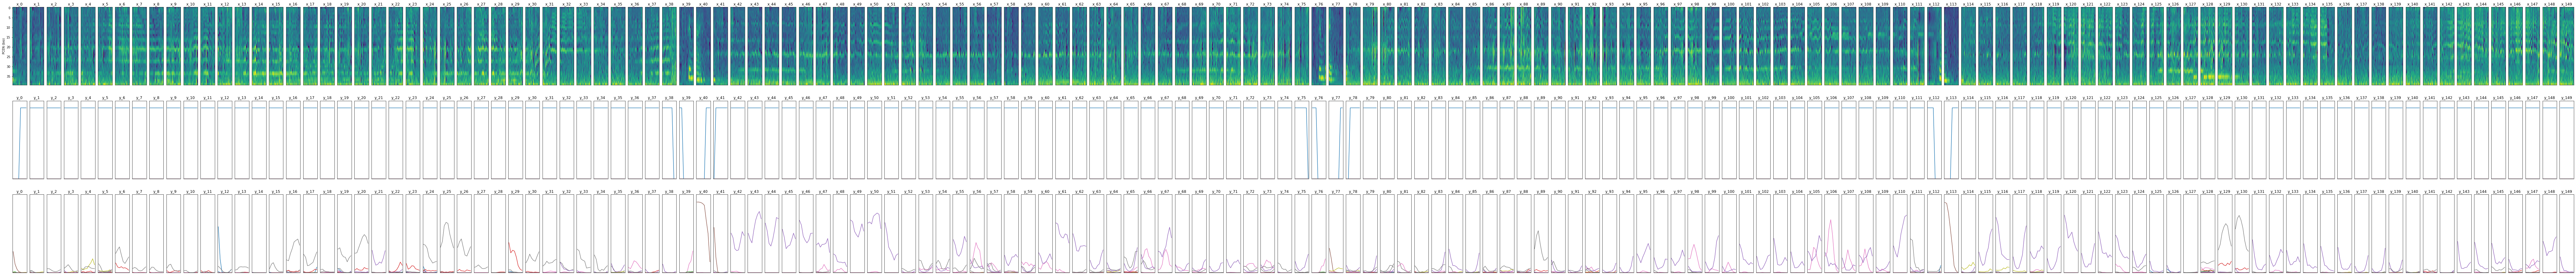

In [128]:
n_segments = np.min((150, valid_dataset.x.shape[0]))

fig, ax = plt.subplots(3, n_segments, figsize=(n_segments, 16))

start_idx = 0

for seg_idx in range(start_idx, start_idx+n_segments):
    ax_idx = seg_idx - start_idx
    
    mel_segment, target_segment = valid_dataset[seg_idx]
    pred_segment = y_preds[seg_idx]

    ax[0, ax_idx].imshow(np.flip(mel_segment, axis=0), aspect='auto')
    ax[0, ax_idx].get_xaxis().set_visible(False)
    ax[0, ax_idx].get_yaxis().set_visible(False)
    ax[0, ax_idx].set_title('x_{}'.format(seg_idx))

    #scales = np.linspace(0.2, 1.0, len(target_segment))
    for i, ann in enumerate(target_segment):
        ax[1,ax_idx].plot(ann)
    ax[1,ax_idx].set_ylim([0, 1.1])
    ax[1, ax_idx].get_xaxis().set_visible(False)
    ax[1, ax_idx].get_yaxis().set_visible(False)
    ax[1, ax_idx].set_title('y_{}'.format(seg_idx))
    
    for i, ann in enumerate(pred_segment):
        ax[2,ax_idx].plot(ann)
    ax[2,ax_idx].set_ylim([0, 1.1])
    ax[2, ax_idx].get_xaxis().set_visible(False)
    ax[2, ax_idx].get_yaxis().set_visible(False)
    ax[2, ax_idx].set_title('y_{}'.format(seg_idx))
    
ax[0,0].set_ylabel('PCEN (bio)')
ax[0,0].get_yaxis().set_visible(True)

In [129]:
# 1. In DCASE data loading, define a way to only load the data for the first 5 annotations
# 2. Make predictions according to similarity to prototype, and visualize like this.
# 3. Produce a prediction file, and compute final score.

In [130]:
# 1. Create positive prototype
# 2. Create negative prototype

In [131]:
def is_negative(target):
    return (np.sum(target[:,0:n_classes,:], axis=(1, 2)) == 0)

def is_positive(target):
    return np.sum(target[:,0:n_classes,:], axis=(1, 2)) > 0

def create_prototypes(valid_loader, model, use_embeddings=True):
    y_preds      = []
    embeddings   = []
    neg_bool_idx = []
    
    for (x, y) in valid_loader:
        x = x.view((x.shape[0], 1, x.shape[1], x.shape[2])).double()
        x = x.cuda()
        logits, embedding = model(x)
        y_pred = torch.sigmoid(logits)
        
        y_preds.append(y_pred.detach().cpu().numpy())        
        neg_bool_idx.append(is_negative(y.detach().cpu().numpy()))
        embeddings.append(embedding.detach().cpu().numpy())
        
    embeddings = np.concatenate(embeddings)
    print("embeddings: ", embeddings.shape)
    
    y_preds = np.concatenate(y_preds)
    print("y_preds: ", y_preds.shape)
    
    neg_bool_idx = np.concatenate(neg_bool_idx)
    print("negs: ", np.sum(neg_bool_idx))
    
    if use_embeddings:
        n_prototypes = embeddings[neg_bool_idx]
        p_prototypes = embeddings[~neg_bool_idx]
    else:
        n_prototypes = y_preds[neg_bool_idx]
        p_prototypes = y_preds[~neg_bool_idx]
    
    n_prototype = np.mean(n_prototypes, axis=0)
    p_prototype = np.mean(p_prototypes, axis=0)
    
    return n_prototype, p_prototype

def create_positive_prototype(dataset):
    targets = dataset.y
    sg_bool_idx = np.sum(targets[:,0:n_classes,:], axis=(1, 2)) > 0
    return p_prototype

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum(np.power(x1-x2, 2)))

def softmax(x, temp):
    return np.exp(x/temp)/np.sum(np.exp(x/temp))

def classify(query, n_prototype, p_prototype):
    
    d_n = euclidean_distance(query, n_prototype)
    d_p = euclidean_distance(query, p_prototype)
    x = np.array([d_n, d_p]) # TODO: 1/d_n ?
    
    y = softmax(x, 1)
    y = np.expand_dims(y, axis=0)
    y = np.expand_dims(y, axis=2)
    y = np.repeat(y, n_time, axis=2)
    return y

In [132]:
n_prototype, p_prototype = create_prototypes(valid_loader, model, use_embeddings=True)

embeddings:  (266, 128)
y_preds:  (266, 48, 8)
negs:  100


# Evaluate the model

In [133]:
n_shot = 50000000000
n_background = 500000000000

valid_dataset = dcase_dataset.BioacousticDataset(
    root_dir           = csv_path,
    window_size        = window_size,
    hop_size           = hop_size,
    sample_rate        = sample_rate,
    n_classes          = n_classes,
    n_time             = n_time,
    n_shot             = n_shot,
    n_background       = n_background,
    transform          = transform_pcen_bio,
    cache              = False,
    is_validation_data = True
)

print(len(valid_dataset))

valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=8)

  0%|          | 0/1 [00:00<?, ?it/s]

building dataset ...


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

3902


In [134]:
embeddings   = []
for (x, _) in valid_loader:
    x = x.view((x.shape[0], 1, x.shape[1], x.shape[2])).double()
    x = x.cuda()
    logits, embedding = model(x)     
    embeddings.append(embedding.detach().cpu().numpy())

embeddings = np.concatenate(embeddings)
print("embeddings: ", embeddings.shape)

embeddings:  (3902, 128)


In [135]:
y_preds = []
for query in embeddings:
    y_pred = classify(query, n_prototype, p_prototype)
    y_preds.append(y_pred)
y_preds = np.concatenate(y_preds)

In [136]:
print(y_preds.shape)

(3902, 2, 8)


## Visualize results

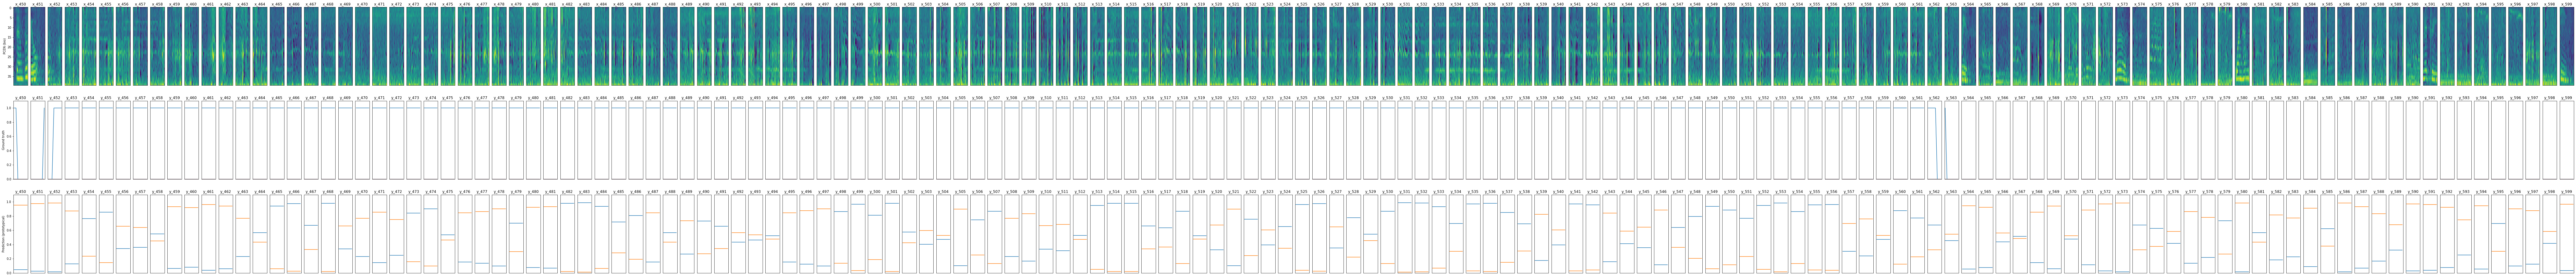

In [142]:
n_segments = np.min((150, valid_dataset.x.shape[0]))

fig, ax = plt.subplots(3, n_segments, figsize=(n_segments, 16))

start_idx = 450

for seg_idx in range(start_idx, start_idx+n_segments):
    ax_idx = seg_idx - start_idx
    
    mel_segment, target_segment = valid_dataset[seg_idx]
    pred_segment = y_preds[seg_idx]

    ax[0, ax_idx].imshow(np.flip(mel_segment, axis=0), aspect='auto')
    ax[0, ax_idx].get_xaxis().set_visible(False)
    ax[0, ax_idx].get_yaxis().set_visible(False)
    ax[0, ax_idx].set_title('x_{}'.format(seg_idx))

    #scales = np.linspace(0.2, 1.0, len(target_segment))
    for i, ann in enumerate(target_segment):
        ax[1,ax_idx].plot(ann)
    ax[1,ax_idx].set_ylim([0, 1.1])
    ax[1, ax_idx].get_xaxis().set_visible(False)
    ax[1, ax_idx].get_yaxis().set_visible(False)
    ax[1, ax_idx].set_title('y_{}'.format(seg_idx))
    
    for i, ann in enumerate(pred_segment):
        ax[2,ax_idx].plot(ann)
    ax[2,ax_idx].set_ylim([0, 1.1])
    ax[2, ax_idx].get_xaxis().set_visible(False)
    ax[2, ax_idx].get_yaxis().set_visible(False)
    ax[2, ax_idx].set_title('y_{}'.format(seg_idx))
    
ax[0,0].set_ylabel('PCEN (bio)')
ax[0,0].get_yaxis().set_visible(True)
ax[1,0].set_ylabel('Ground truth')
ax[1,0].get_yaxis().set_visible(True)
ax[2,0].set_ylabel('Prediction (prototypical)')
ax[2,0].get_yaxis().set_visible(True)

In [141]:
# There will be a problem with the 'beginning', 'middle', 'end' idea if they are very uneven. How do we Handle this? Maybe some form of averaging.

In [144]:
# |b|b|m|m|m|m|m|m|m|s|s|, run this type of window over the data. Use the same for the negative prototype.
#
# We call this a temporal prototype.
# 
# Try some different similarity measures.
# 1. Euclidean distance
# 2. hidden Markov model
# 3. anything else?